In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg

    
import os.path as osp
import os
from PIL import Image

In [2]:
CNT_PTHS = ["/home/alma/w-projects/ccf/data/developmental-heart/w_10/anndata/V10F24-105_A1.h5ad",
            "/home/alma/w-projects/ccf/data/developmental-heart/w_10/anndata/V10F24-105_B1.h5ad",
            "/home/alma/w-projects/ccf/data/developmental-heart/w_10/anndata/V10F24-105_C1.h5ad",
            "/home/alma/w-projects/ccf/data/developmental-heart/w_10/anndata/V10F24-105_D1.h5ad",
           ]

In [3]:
REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/dev-heart"

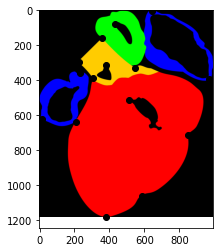

In [4]:
ref_img = Image.open(osp.join(REF_DIR,"dev-heart-black-001.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"dev-heart_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "black")


In [5]:
help(eg.pp.reference_to_grid)

Help on function reference_to_grid in module eggplant.preprocess:

reference_to_grid(ref_img: Union[PIL.Image.Image, str], n_approx_points: int = 10000.0, background_color: Union[str, numpy.ndarray, tuple] = 'white', n_regions: int = 2) -> numpy.ndarray



In [6]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                       n_approx_points=10000,
                                       n_regions=4,
                                       background_color = "black",
                                      )

In [7]:
n_lmk = ref_lmk.shape[0]
lmk_cmap = {0:"blue",1:"red",2:"green",3:"yellow",4:"magenta"}

In [8]:
mta_cmap = {0:"red",1:"blue",2:"green",3:"yellow"}

In [9]:
n_lmk

15

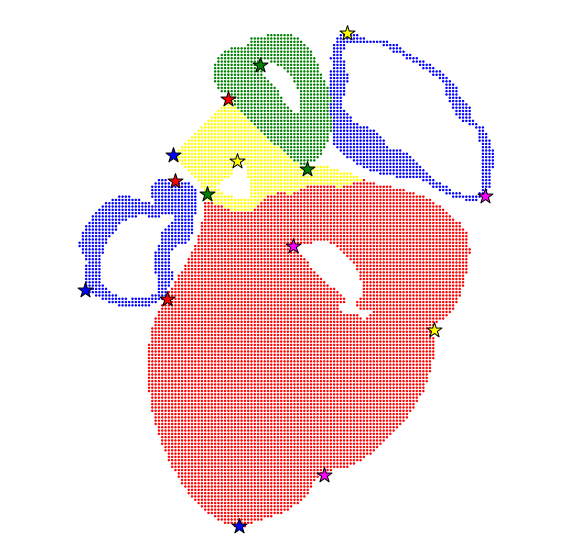

In [10]:
plt.figure(figsize=(10,10),facecolor ="white")
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c = [mta_cmap[x] for x in mta],s = 2)

plt.axis("equal")
plt.axis("off")
for ii in range(n_lmk):
    plt.scatter(ref_lmk.x_coord.values[ii],
                ref_lmk.y_coord.values[ii],
                c = lmk_cmap[ii % len(lmk_cmap)],
                marker = "*",
                edgecolor ="black",
                s = 250,
               )

plt.gca().invert_yaxis()
plt.show()

In [11]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                     meta = dict(region = mta),
                    )

/home/alma/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
for a in adatas:
    print(a)

AnnData object with n_obs × n_vars = 2169 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2246 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2250 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2513 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'


In [14]:
adatas = {f"dh{l}":adatas[k] for k,l in enumerate(["A","B","C","D"])}#,"dhB":adatas[1]}

In [15]:
columns = ["x_coord","y_coord"]
for key in adatas.keys():
    n_lmk_a = adatas[key].uns["curated_landmarks"].shape[0]
    index = [f"L{k}" for k in range(n_lmk_a)]
    adatas[key].uns["curated_landmarks"] = pd.DataFrame(adatas[key].uns["curated_landmarks"],
                                                       columns = columns,
                                                        index = index,
                                                       )

In [16]:
for adata in adatas.values():
    # standard normalization steps
    sc.pp.filter_genes(adata,
                       min_cells = 0.1)
    
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    #--- eggplant specific pre-processing---
    # match scales
    eg.pp.match_scales(adata,ref)
    # perform TPS warping and calculate landmark distances
    eg.pp.get_landmark_distance(adata,
                                reference=ref)



/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/alma/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '2.6.8' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not un

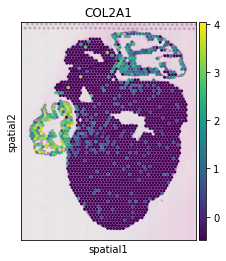

In [38]:
sc.pl.spatial(adatas["dhA"],color ="COL2A1",size=0.4e-4)

In [21]:
np.random.seed(1337)
genes = ["POSTN","COL2A1"]#"MYH10","MYH7","TSHZ2","COL1A1"]
idx = np.random.choice(len(adatas["dhA"]),
                       replace = False,
                       size = 1500)

losses = eg.fun.transfer_to_reference(adatas,
                                      genes,
                                      ref,
                                      n_epochs=1000,
                                      device ="cpu",
                                      verbose = True,
                                      return_losses = True,
                                      return_models =False,
                                      max_cg_iterations = 10000,
                                      )

Processing >> Model : dhA | Feature : POSTN


  0%|          | 0/1000 [00:00<?, ?it/s]/home/alma/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]


Processing >> Model : dhA | Feature : COL2A1


100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


Processing >> Model : dhB | Feature : POSTN


/home/alma/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


Processing >> Model : dhB | Feature : COL2A1


100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]


Processing >> Model : dhC | Feature : POSTN


100%|██████████| 1000/1000 [02:30<00:00,  6.66it/s]


Processing >> Model : dhC | Feature : COL2A1


100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


Processing >> Model : dhD | Feature : POSTN


100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


Processing >> Model : dhD | Feature : COL2A1


100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


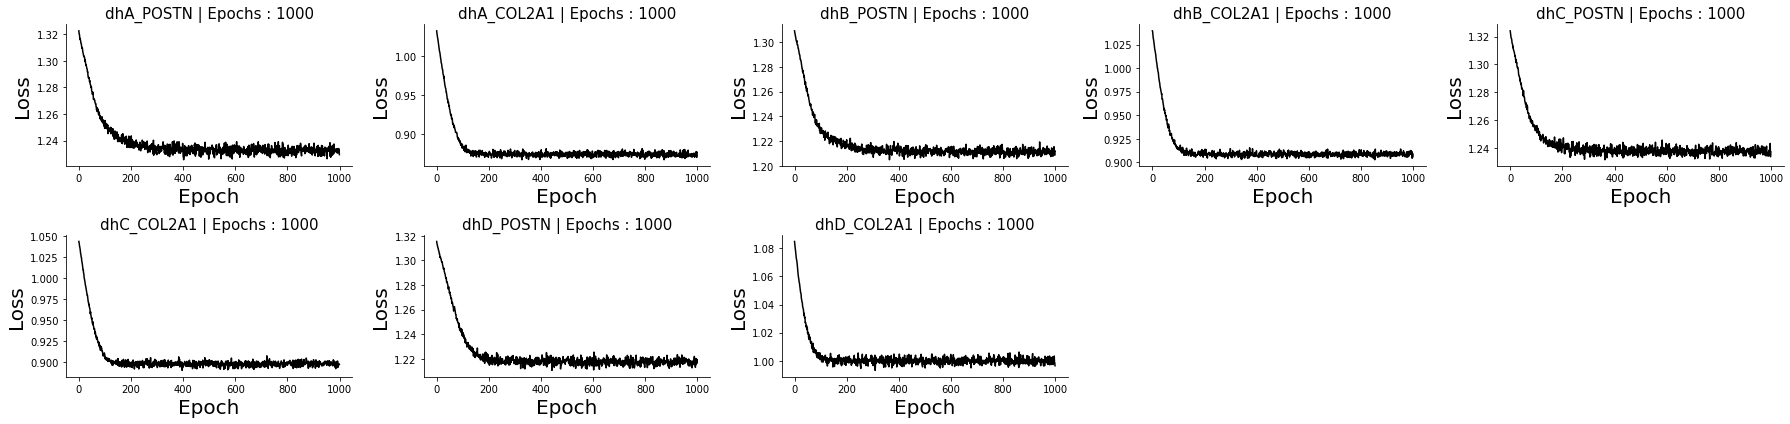

In [22]:
eg.pl.model_diagnostics(losses = losses)

(-0.041806021332740785, 0.8779264479875565, -0.05, 1.05)

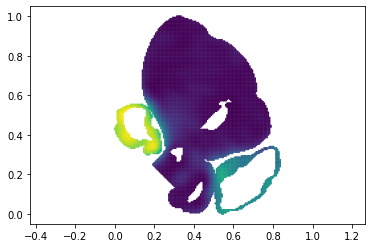

In [36]:
plt.scatter(ref.adata.obsm["spatial"][:,0],
            ref.adata.obsm["spatial"][:,1],
            c = ref.adata.X[:,ref.adata.var["feature"].values == "POSTN" ].mean(axis=1),
            s = 0.9,
           )
plt.axis("equal")

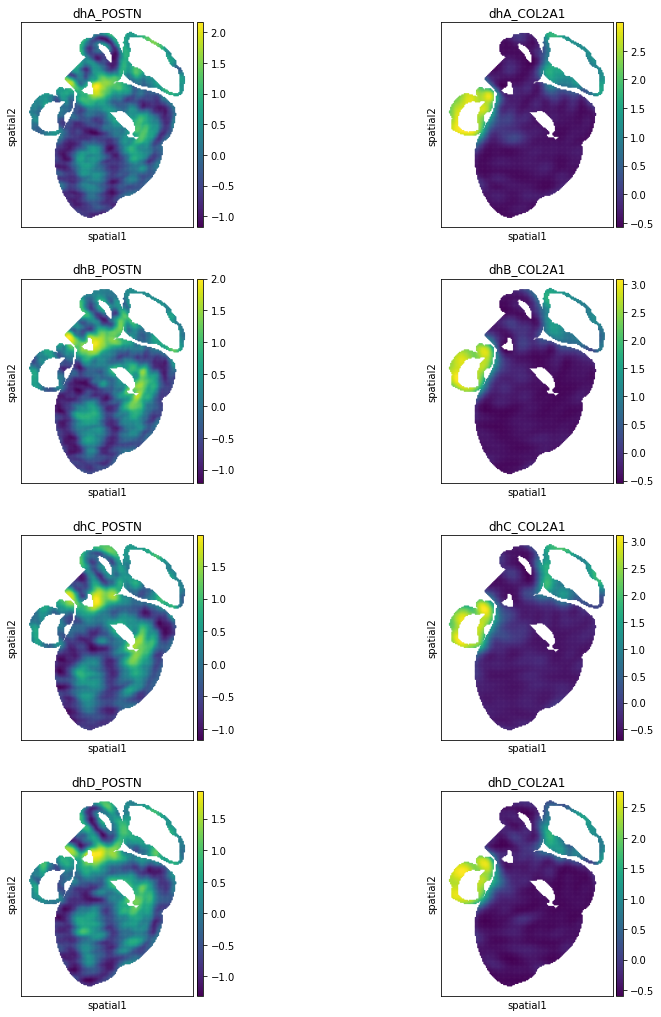

In [50]:
ref.plot(spot_size = 0.011,ncols = 2)

In [54]:
ref.adata.var

,feature,model
dhA_POSTN,POSTN,dhA
dhA_COL2A1,COL2A1,dhA
dhB_POSTN,POSTN,dhB
dhB_COL2A1,COL2A1,dhB
dhC_POSTN,POSTN,dhC
dhC_COL2A1,COL2A1,dhC
dhD_POSTN,POSTN,dhD
dhD_COL2A1,COL2A1,dhD


In [59]:
eval("adata.{}['{}']".format(*outside))

dhA_POSTN      POSTN
dhA_COL2A1    COL2A1
dhB_POSTN      POSTN
dhB_COL2A1    COL2A1
dhC_POSTN      POSTN
dhC_COL2A1    COL2A1
dhD_POSTN      POSTN
dhD_COL2A1    COL2A1
Name: feature, dtype: category
Categories (2, object): ['COL2A1', 'POSTN']

In [73]:
sel_id_out = eval("adata.{}['{}'].values".format(*outside)) == out
sel_id_out

array([False,  True, False,  True, False,  True, False,  True])

In [ ]:
import matplotlib

In [170]:
from typing import Dict,Optional,Any
def swarmplot_transfer(ref: "m.Reference",
                       inside: Dict[str,str],
                       outside: Optional[Dict[str,str]] = None,
                       n_cols: Optional[int] = None,
                       n_rows: Optional[int] = None,
                       side_size: float = 4.0,
                       swarm_marker_style: Optional[Dict[str,Any]] = None,
                       mean_marker_style: Optional[Dict[str,Any]] = None,
                       display_grid: bool = True,
                       title_fontsize: float = 25,
                       label_fontsize: float = 20,
                       ticks_fontsize: float = 15,
                       return_figure: bool = True,
                       )->Optional[Tuple[plt.Figure,plt.Axes]]:

    adata = ref.adata

    _swarm_marker_style =  dict(s = 0.1,
                              c = "black",
                              alpha = 0.6,
                              )

    if swarm_marker_style is not None:
        for k,v in swarm_marker_style.items():
            _swarm_marker_style[k] = v

    _mean_marker_style = dict(s = 90,
                                marker ="d",
                                c = "#D2D811",
                                edgecolor ="#696C05",
                                zorder = np.inf,
                                )
    
    
    if mean_marker_style is not None:
        for k,v in mean_marker_style.items():
            _mean_marker_style[k] = v


    in_vals = eval("adata.{attribute}['{column}'].values".format(**inside))
    uni_in = np.unique(in_vals)

    if outside is not None:
        out_vals = eval("adata.{attribute}['{column}'].values".format(**outside))
        uni_out = np.unique(out_vals)
    else:
        uni_out = [None]
        axis_out = (1 if inside["attribute"] == "obs" else 0)
        sel_id_out = np.array([True] * adata.shape[axis_out])

    n_rows,n_cols = eg.ut.get_figure_dims(len(uni_out),n_rows,n_cols)
    figsize = (n_cols * side_size,n_rows * side_size)
    fig,ax = plt.subplots(n_rows,n_cols,figsize = figsize)
    ax = ax.flatten()


    for ii,out in enumerate(uni_out):
        if outside is not None:
            sel_id_out = out_vals == out
        for jj,ins in enumerate(uni_in):
            sel_id_in = in_vals == ins
            if inside["attribute"] == "obs":
                ys = adata.X[sel_id_in,:][:,sel_id_out].mean(axis=1)
            else:
                ys = adata.X[sel_id_out,:][:,sel_id_in].mean(axis=0)

            xs = np.random.normal(jj,0.1,size = len(ys))

            ax[ii].scatter(xs,
                           ys,
                           **_swarm_marker_style,
                          )

            ax[ii].scatter(jj,
                           ys.mean(),
                           **_mean_marker_style,
                           )
            
            
        
        if outside is not None:
            ax[ii].set_xlabel(inside["column"],fontsize = 0.8 * title_fontsize)
        ax[ii].set_ylabel(outside["column"],fontsize = 0.8 * title_fontsize)


        ax[ii].set_xticks(np.arange(len(uni_in)))
        ax[ii].set_xticklabels(uni_in,rotation = 90)
        ax[ii].set_title(out,fontsize = title_fontsize)
        ax[ii].tick_params(axis="both",
                           which = "major",
                           labelsize=ticks_fontsize)

        if display_grid:
            ax[ii].grid(True,
                        which = "major",
                        axis="x",
                        zorder = 0,
                        color = "black",
                        linestyle = "dashed",
                    )
    for axx in ax[ii+1:]:
        axx.axis("off")
            
    fig.tight_layout()

    if return_figure:
        return (fig,ax)
    else:
        plt.show()
        return None


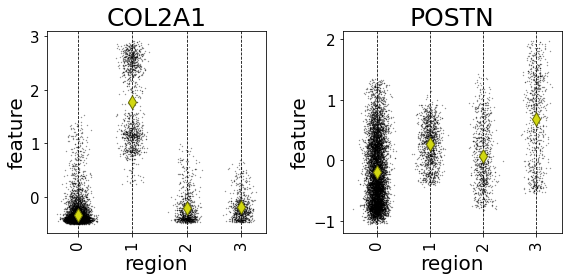

In [171]:

outside = {"attribute":"var","column":"feature"}
inside = {"attribute":"obs","column":"region"}

swarmplot_transfer(ref,
                   inside,
                   outside,
                   return_figure=False,
                   n_cols = 2,
                  )
